# Exploitation des descriptions des Soil_Type

In [87]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv')

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On divise les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# On normalise les données continues 
from sklearn.preprocessing import StandardScaler

continuous_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                      'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                      'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
scaler = StandardScaler()

# On applique le scaler uniquement sur les colonnes continues
#X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
#X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

# On ajuste les labels pour qu'ils commencent à 0 pour XGBoost
y_train_adj = y_train - 1
y_test_adj = y_test - 1

Pour exploiter les descriptions associées aux attributs Soil_Type, on utilise l’encodage de texte pour capturer les similitudes entre les descriptions. L’idée est de représenter chaque description sous forme d’un vecteur dense (embedding) de manière à ce que les descriptions proches aient des vecteurs proches.

## Étape 1 : Organiser les Descriptions dans un Dictionnaire

Voici le dictionnaire qui associe chaque Soil_Type à sa description :

In [90]:
soil_type_descriptions = {
    "Soil_Type1": "ELU 2702, Cathedral family - Rock outcrop complex, extremely stony.",
    "Soil_Type2": "ELU 2703, Vanet - Ratake families complex, very stony.",
    "Soil_Type3": "ELU 2704, Haploborolis - Rock outcrop complex, rubbly.",
    "Soil_Type4": "ELU 2705, Ratake family - Rock outcrop complex, rubbly.",
    "Soil_Type5": "ELU 2706, Vanet family - Rock outcrop complex complex, rubbly.",
    "Soil_Type6": "ELU 2717, Vanet - Wetmore families - Rock outcrop complex, stony.",
    "Soil_Type7": "ELU 3501, Gothic family.",
    "Soil_Type8": "ELU 3502, Supervisor - Limber families complex.",
    "Soil_Type9": "ELU 4201, Troutville family, very stony.",
    "Soil_Type10": "ELU 4703, Bullwark - Catamount families - Rock outcrop complex, rubbly.",
    "Soil_Type11": "ELU 4704, Bullwark - Catamount families - Rock land complex, rubbly.",
    "Soil_Type12": "ELU 4744, Legault family - Rock land complex, stony.",
    "Soil_Type13": "ELU 4758, Catamount family - Rock land - Bullwark family complex, rubbly.",
    "Soil_Type14": "ELU 5101, Pachic Argiborolis - Aquolis complex.",
    "Soil_Type15": "ELU 5151, unspecified in the USFS Soil and ELU Survey.",
    "Soil_Type16": "ELU 6101, Cryaquolis - Cryoborolis complex.",
    "Soil_Type17": "ELU 6102, Gateview family - Cryaquolis complex.",
    "Soil_Type18": "ELU 6731, Rogert family, very stony.",
    "Soil_Type19": "ELU 7101, Typic Cryaquolis - Borohemists complex.",
    "Soil_Type20": "ELU 7102, Typic Cryaquepts - Typic Cryaquolls complex.",
    "Soil_Type21": "ELU 7103, Typic Cryaquolls - Leighcan family, till substratum complex.",
    "Soil_Type22": "ELU 7201, Leighcan family, till substratum, extremely bouldery.",
    "Soil_Type23": "ELU 7202, Leighcan family, till substratum - Typic Cryaquolls complex.",
    "Soil_Type24": "ELU 7700, Leighcan family, extremely stony.",
    "Soil_Type25": "ELU 7701, Leighcan family, warm, extremely stony.",
    "Soil_Type26": "ELU 7702, Granile - Catamount families complex, very stony.",
    "Soil_Type27": "ELU 7709, Leighcan family, warm - Rock outcrop complex, extremely stony.",
    "Soil_Type28": "ELU 7710, Leighcan family - Rock outcrop complex, extremely stony.",
    "Soil_Type29": "ELU 7745, Como - Legault families complex, extremely stony.",
    "Soil_Type30": "ELU 7746, Como family - Rock land - Legault family complex, extremely stony.",
    "Soil_Type31": "ELU 7755, Leighcan - Catamount families complex, extremely stony.",
    "Soil_Type32": "ELU 7756, Catamount family - Rock outcrop - Leighcan family complex, extremely stony.",
    "Soil_Type33": "ELU 7757, Leighcan - Catamount families - Rock outcrop complex, extremely stony.",
    "Soil_Type34": "ELU 7790, Cryorthents - Rock land complex, extremely stony.",
    "Soil_Type35": "ELU 8703, Cryumbrepts - Rock outcrop - Cryaquepts complex.",
    "Soil_Type36": "ELU 8707, Bross family - Rock land - Cryumbrepts complex, extremely stony.",
    "Soil_Type37": "ELU 8708, Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.",
    "Soil_Type38": "ELU 8771, Leighcan - Moran families - Cryaquolls complex, extremely stony.",
    "Soil_Type39": "ELU 8772, Moran family - Cryorthents - Leighcan family complex, extremely stony.",
    "Soil_Type40": "ELU 8776, Moran family - Cryorthents - Rock land complex, extremely stony."
}

## Étape 2 : Encoder les Descriptions avec SentenceTransformers

Nous allons utiliser SentenceTransformers pour obtenir des vecteurs pour chaque description.

In [91]:
from sentence_transformers import SentenceTransformer

In [92]:
# Charger le modèle pré-entraîné
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encodage des descriptions en vecteurs
soil_embeddings = {soil: model.encode(desc) for soil, desc in soil_type_descriptions.items()}

# Exemple de vecteur pour Soil_Type1
print(f"Vecteur pour Soil_Type1 : {soil_embeddings['Soil_Type1']}")

Vecteur pour Soil_Type1 : [-3.98341427e-03  1.49687482e-02  9.62809194e-03  2.90642865e-02
 -4.65176553e-02 -5.71908653e-02 -9.18270126e-02 -1.10826734e-02
 -1.45601630e-02  2.17754710e-02 -4.63890471e-02 -9.28444192e-02
  4.47193272e-02 -7.45228156e-02 -2.60607526e-02  3.95468064e-03
  9.20382980e-03 -7.92657211e-02  2.12561004e-02  7.90683329e-02
  2.13512182e-02  5.11701293e-02 -4.17153500e-02  8.54034424e-02
 -2.39577126e-02  1.61932241e-02 -5.45800291e-02 -1.53613696e-03
  3.01984604e-02 -1.16783515e-01  5.94906099e-02  3.00413482e-02
  2.41216943e-02 -2.79328953e-02  4.21277694e-02  9.09229368e-02
  1.13450158e-02 -3.04119587e-02  3.22764516e-02  1.52649153e-02
 -5.22041209e-02  5.35554290e-02  1.36809185e-01 -3.46505940e-02
  4.13564779e-02 -1.73292588e-02 -3.16283442e-02 -5.73635809e-02
 -1.20584266e-02  3.59880663e-02  9.59695689e-03 -7.02284798e-02
  1.08465003e-02 -1.16220573e-02 -7.00480044e-02  9.71686766e-02
 -2.29855962e-02 -3.61740924e-02  6.31231219e-02  2.46676020e-02

## Étape 3 : Associer les Vecteurs au Dataset

In [93]:
def add_soil_embeddings(df, soil_embeddings):
    # Dimension des vecteurs (ex. : 384 pour all-MiniLM-L6-v2)
    embedding_dim = len(next(iter(soil_embeddings.values())))

    # Initialiser les colonnes des embeddings
    for i in range(embedding_dim):
        df[f'soil_embedding_{i}'] = 0.0
    
    # Remplir les colonnes avec les embeddings
    for index, row in df.iterrows():
        for soil_type, embedding in soil_embeddings.items():
            if row[soil_type] == 1:  # Si le Soil_Type est actif
                for i, value in enumerate(embedding):
                    df.at[index, f'soil_embedding_{i}'] = value
                break
    return df

In [94]:
# Appliquer les embeddings au DataFrame
X_train = add_soil_embeddings(X_train, soil_embeddings)
X_test = add_soil_embeddings(X_test, soil_embeddings)

/var/folders/24/f9mpl0gx1rs5tb1xb_z_cqmw0000gn/T/ipykernel_33154/3717472228.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'soil_embedding_{i}'] = 0.0
/var/folders/24/f9mpl0gx1rs5tb1xb_z_cqmw0000gn/T/ipykernel_33154/3717472228.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'soil_embedding_{i}'] = 0.0
/var/folders/24/f9mpl0gx1rs5tb1xb_z_cqmw0000gn/T/ipykernel_33154/3717472228.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

In [95]:
print(X_train.shape)
print(X_train.head())

(10584, 439)
           Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
13795  459767       3321      64     15                                90   
6483     5991       2367      57     16                                 0   
6236   283084       2397     138     32                               234   
14949   14060       3319     175     13                              1104   
2172    98425       2974      94     11                               240   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
13795                             -13                             2058   
6483                                0                              760   
6236                              142                             1507   
14949                             145                             2530   
2172                               37                             4128   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  soil_embedding_374  \

## Test et tuning des modèles classiques prometteurs

In [47]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

### Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

# On initialise et entraîner le modèle de Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# On prédit sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# On évalue les performances
print("Précision Random Forest : ", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Précision Random Forest :  0.8527336860670194
              precision    recall  f1-score   support

           1       0.75      0.76      0.75       648
           2       0.76      0.67      0.71       648
           3       0.84      0.85      0.84       648
           4       0.95      0.97      0.96       648
           5       0.90      0.92      0.91       648
           6       0.83      0.86      0.85       648
           7       0.92      0.93      0.93       648

    accuracy                           0.85      4536
   macro avg       0.85      0.85      0.85      4536
weighted avg       0.85      0.85      0.85      4536



Optimisation des hyperparamètres :

In [48]:
# On définit l'espace de recherche pour Random Forest
space_rf = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'max_depth': hp.choice('max_depth', [5, 10, 15, 20, None]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4]),
    'max_features': hp.choice('max_features', ['sqrt', 'log2'])  # Correction : 'auto' remplacé par 'sqrt'
}

# On crée la fonction objectif pour Random Forest
def objective_rf(params):
    # On initialise le modèle avec les paramètres proposés
    model = RandomForestClassifier(**params, random_state=42)
    # On effectue une validation croisée pour évaluer la performance
    score = cross_val_score(model, X_train, y_train, cv=7, scoring='accuracy').mean()
    # On retourne la perte (score négatif) car Hyperopt minimise cette fonction
    return {'loss': -score, 'status': STATUS_OK}

# On lance Hyperopt pour optimiser les hyperparamètres de Random Forest
trials_rf = Trials()
best_params_rf = fmin(fn=objective_rf, space=space_rf, algo=tpe.suggest, max_evals=50, trials=trials_rf)
print("Meilleurs paramètres Random Forest :", best_params_rf)

100%|██████████| 50/50 [18:53<00:00, 22.67s/trial, best loss: -0.8558201058201058]
Meilleurs paramètres Random Forest : {'max_depth': 4, 'max_features': 0, 'min_samples_leaf': 0, 'min_samples_split': 0, 'n_estimators': 4}


In [49]:
# Traduction des indices en valeurs concrètes
best_rf_params = {
    'max_depth': [5, 10, 15, 20, None][4],           
    'max_features': ['sqrt', 'log2'][0],             
    'min_samples_leaf': [1, 2, 4][0],                
    'min_samples_split': [2, 5, 10][0],              
    'n_estimators': [100, 200, 300, 400, 500][4]     
}

# Initialiser le modèle avec les valeurs concrètes
rf_model = RandomForestClassifier(**best_rf_params, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
rf_model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Évaluer les performances du modèle
from sklearn.metrics import accuracy_score, classification_report
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Précision Random Forest :", accuracy_rf)
print("Rapport de classification Random Forest :\n", classification_report(y_test, y_pred_rf))

Précision Random Forest : 0.8525132275132276
Rapport de classification Random Forest :
               precision    recall  f1-score   support

           1       0.75      0.76      0.75       648
           2       0.77      0.67      0.72       648
           3       0.83      0.85      0.84       648
           4       0.95      0.97      0.96       648
           5       0.90      0.93      0.91       648
           6       0.84      0.85      0.85       648
           7       0.92      0.93      0.93       648

    accuracy                           0.85      4536
   macro avg       0.85      0.85      0.85      4536
weighted avg       0.85      0.85      0.85      4536



Les embeddings ajoutent des dimensions à nos données. Si ces nouvelles dimensions ne sont pas corrélées avec la variable cible (Cover_Type), elles risquent de réduire la performance.

On vérifie la corrélation avec des outils comme l’importance des caractéristiques (Feature Importance).

                                Feature  Importance
1                             Elevation    0.109530
0                                    Id    0.089415
6       Horizontal_Distance_To_Roadways    0.062420
10   Horizontal_Distance_To_Fire_Points    0.057578
4      Horizontal_Distance_To_Hydrology    0.049454
..                                  ...         ...
48                          Soil_Type34    0.000000
278                  soil_embedding_223    0.000000
182                  soil_embedding_127    0.000000
39                          Soil_Type25    0.000000
42                          Soil_Type28    0.000000

[439 rows x 2 columns]


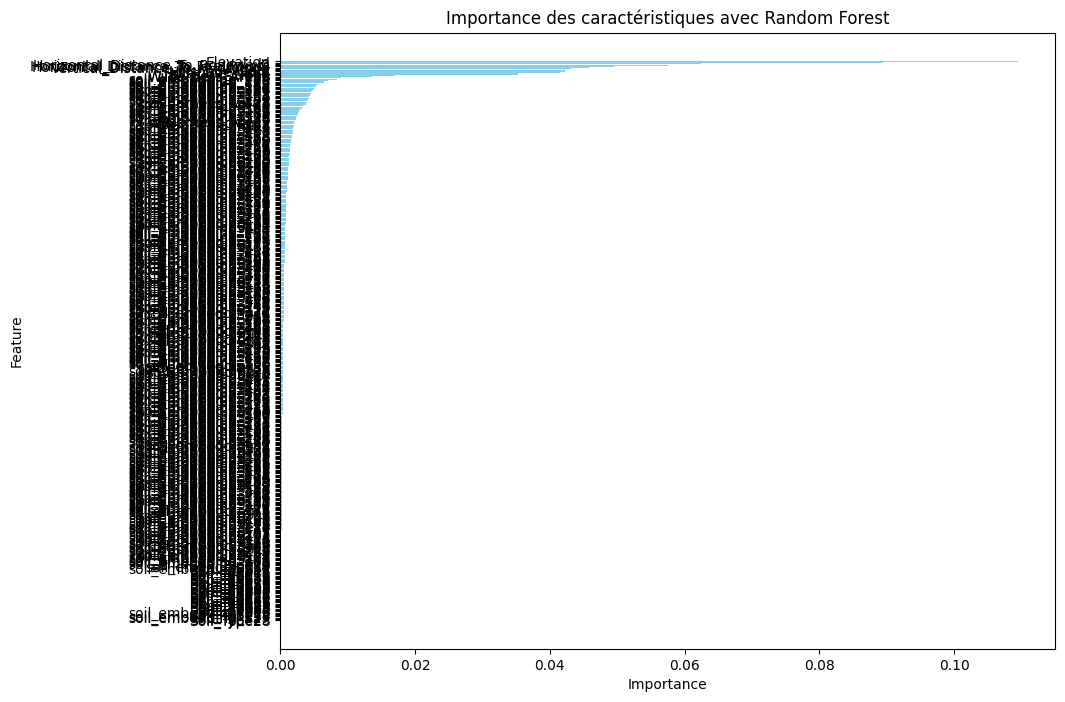

In [53]:
# On récupère les importances des features
features_importances = rf_model.feature_importances_

# On crée un DataFrame pour visualiser les importances des features
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': features_importances
})

# On trie les features par importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Affiche le DataFrame trié (facultatif)
print(importance_df)

# Visualiser les importances des caractéristiques
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Importance des caractéristiques avec Random Forest")
plt.gca().invert_yaxis()  # Inverser l'axe y pour voir les caractéristiques les plus importantes en haut
plt.show()

L'ajout des embeddings n'est pas prometteur mais on essaie avec les autres modèles.

### XGBoost

In [55]:
import xgboost as xgb

# Paramètres de XGBoost
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=7, 
                              n_estimators=300, max_depth=10, learning_rate=0.1, 
                              subsample=0.8, colsample_bytree=0.8, random_state=42)

# On entraîne le modèle
xgb_model.fit(X_train, y_train_adj)

# On prédit sur l'ensemble de test
y_pred_xgb = xgb_model.predict(X_test)

# On évalue les performances
print("Précision XGBoost : ", accuracy_score(y_test_adj, y_pred_xgb))
print(classification_report(y_test_adj, y_pred_xgb))

Précision XGBoost :  0.8899911816578483
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       648
           1       0.81      0.74      0.77       648
           2       0.88      0.90      0.89       648
           3       0.95      0.98      0.96       648
           4       0.92      0.95      0.93       648
           5       0.91      0.90      0.91       648
           6       0.94      0.96      0.95       648

    accuracy                           0.89      4536
   macro avg       0.89      0.89      0.89      4536
weighted avg       0.89      0.89      0.89      4536



Tuning des hyperparamètres :

In [60]:
# On définit l'espace de recherche pour XGBoost
space_xgb = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'max_depth': hp.choice('max_depth', [3, 6, 9, 12]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5)
}

# On crée la fonction objectif pour XGBoost
def objective_xgb(params):
    # On initialise XGBoost avec les paramètres proposés
    model = xgb.XGBClassifier(objective='multi:softmax', num_class=7, **params, random_state=42)
    # On utilise une validation croisée pour calculer la précision
    score = cross_val_score(model, X_train, y_train_adj, cv=7, scoring='accuracy').mean()
    # On retourne la perte (score négatif) car Hyperopt minimise cette fonction
    return {'loss': -score, 'status': STATUS_OK}

# On lance l'optimisation avec Hyperopt pour XGBoost
trials_xgb = Trials()
best_params_xgb = fmin(fn=objective_xgb, space=space_xgb, algo=tpe.suggest, max_evals=50, trials=trials_xgb)
print("Meilleurs paramètres XGBoost :", best_params_xgb)

100%|██████████| 50/50 [37:46<00:00, 45.34s/trial, best loss: -0.8877551020408162]
Meilleurs paramètres XGBoost : {'colsample_bytree': 0.9453525156220277, 'gamma': 0.03417513387113884, 'learning_rate': 0.14979542164470142, 'max_depth': 3, 'n_estimators': 4, 'subsample': 0.8193475504233062}


In [64]:
# On utilise les meilleurs hyperparamètres trouvés par Hyperopt
best_xgb_params = {
    'colsample_bytree': 0.9453525156220277,
    'gamma': 0.03417513387113884,
    'learning_rate': 0.14979542164470142,
    'max_depth': 12,
    'n_estimators': [100, 200, 300, 400, 500][4],  
    'subsample': 0.8193475504233062
}

# Initialiser le modèle XGBoost avec les paramètres optimaux
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=7, **best_xgb_params, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
xgb_model.fit(X_train, y_train_adj)

# Prédire les classes sur l'ensemble de test
y_pred_xgb = xgb_model.predict(X_test)

# Évaluer les performances du modèle
accuracy_xgb = accuracy_score(y_test_adj, y_pred_xgb)
print("Précision du modèle XGBoost :", accuracy_xgb)
print("Rapport de classification XGBoost :\n", classification_report(y_test_adj, y_pred_xgb))

Précision du modèle XGBoost : 0.890652557319224
Rapport de classification XGBoost :
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       648
           1       0.81      0.75      0.78       648
           2       0.89      0.90      0.89       648
           3       0.95      0.97      0.96       648
           4       0.92      0.96      0.94       648
           5       0.90      0.90      0.90       648
           6       0.94      0.96      0.95       648

    accuracy                           0.89      4536
   macro avg       0.89      0.89      0.89      4536
weighted avg       0.89      0.89      0.89      4536



### LightGBM

In [56]:
import lightgbm as lgb

# Paramètres de LightGBM
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=7, 
                               n_estimators=300, max_depth=10, learning_rate=0.1, 
                               subsample=0.8, colsample_bytree=0.8, random_state=42, verbosity=-1)

# On entraîne le modèle
lgb_model.fit(X_train, y_train)

# On prédit sur l'ensemble de test
y_pred_lgb = lgb_model.predict(X_test)

# On évalue les performances
print("\n","Précision LightGBM : ", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



 Précision LightGBM :  0.8877865961199295
              precision    recall  f1-score   support

           1       0.80      0.80      0.80       648
           2       0.79      0.72      0.76       648
           3       0.89      0.90      0.90       648
           4       0.96      0.98      0.97       648
           5       0.92      0.96      0.94       648
           6       0.90      0.91      0.90       648
           7       0.95      0.94      0.95       648

    accuracy                           0.89      4536
   macro avg       0.89      0.89      0.89      4536
weighted avg       0.89      0.89      0.89      4536



Tuining des hyperparamètres :

In [61]:
# On définit l'espace de recherche pour LightGBM
space_lgb = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'max_depth': hp.choice('max_depth', [5, 10, 15, 20, -1]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'num_leaves': hp.choice('num_leaves', [31, 50, 70, 100]),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

# On crée la fonction objectif pour LightGBM
def objective_lgb(params):
    # On initialise LightGBM avec les paramètres proposés
    model = lgb.LGBMClassifier(objective='multiclass', **params, verbosity = -1,random_state=42)
    # On utilise la validation croisée pour évaluer la précision
    score = cross_val_score(model, X_train, y_train, cv=7, scoring='accuracy').mean()
    # On retourne la perte (score négatif) car Hyperopt minimise cette fonction
    return {'loss': -score, 'status': STATUS_OK}

# On lance l'optimisation avec Hyperopt pour LightGBM
trials_lgb = Trials()
best_params_lgb = fmin(fn=objective_lgb, space=space_lgb, algo=tpe.suggest, max_evals=50, trials=trials_lgb)
print("Meilleurs paramètres LightGBM :", best_params_lgb)

100%|██████████| 50/50 [1:43:22<00:00, 124.04s/trial, best loss: -0.8924792139077853]
Meilleurs paramètres LightGBM : {'colsample_bytree': 0.5590837885756397, 'learning_rate': 0.0900411694555096, 'max_depth': 4, 'n_estimators': 3, 'num_leaves': 2, 'subsample': 0.9864118144028762}


In [71]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# Meilleurs paramètres de LightGBM (après avoir traduit les indices en valeurs)
best_lgb_params = {
    'colsample_bytree': 0.5590837885756397,
    'learning_rate': 0.0900411694555096,
    'max_depth': -1,
    'n_estimators': [100, 200, 300, 400, 500][3],  
    'num_leaves': [31, 50, 70, 100][2],             
    'subsample': 0.9864118144028762,
    'verbosity': -1  # Désactive les avertissements pendant l'entraînement
}

# Initialiser le modèle LightGBM avec les paramètres optimisés
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=7, **best_lgb_params, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
lgb_model.fit(X_train, y_train)

# Prédire les classes sur l'ensemble de test
y_pred_lgb = lgb_model.predict(X_test)

# Évaluer les performances du modèle
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("Précision du modèle LightGBM :", accuracy_lgb)
print("Rapport de classification LightGBM :\n", classification_report(y_test, y_pred_lgb))

Précision du modèle LightGBM : 0.8919753086419753
Rapport de classification LightGBM :
               precision    recall  f1-score   support

           1       0.81      0.80      0.80       648
           2       0.81      0.75      0.78       648
           3       0.89      0.90      0.89       648
           4       0.96      0.98      0.97       648
           5       0.93      0.96      0.94       648
           6       0.90      0.92      0.91       648
           7       0.95      0.94      0.95       648

    accuracy                           0.89      4536
   macro avg       0.89      0.89      0.89      4536
weighted avg       0.89      0.89      0.89      4536



### Extra Trees

In [57]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialiser ExtraTreesClassifier avec des hyperparamètres
extra_trees = ExtraTreesClassifier(
    n_estimators=200,  # Nombre d'arbres
    max_depth=None,    # Profondeur maximale (None permet de croître jusqu'à la pureté maximale)
    min_samples_split=2,  # Nombre minimum d'échantillons pour diviser un nœud
    min_samples_leaf=1,   # Nombre minimum d'échantillons pour former une feuille
    max_features='sqrt',  # Nombre de caractéristiques à considérer pour chaque division
    random_state=42,
    n_jobs=-1  # Utilisation de tous les cœurs disponibles pour l'entraînement
)

# Entraîner le modèle sur les données d'entraînement
extra_trees.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = extra_trees.predict(X_test)

# Évaluer les performances
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle ExtraTrees : {accuracy:.4f}")
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Précision du modèle ExtraTrees : 0.8556
Rapport de classification :
               precision    recall  f1-score   support

           1       0.76      0.77      0.76       648
           2       0.77      0.69      0.72       648
           3       0.85      0.85      0.85       648
           4       0.95      0.97      0.96       648
           5       0.90      0.91      0.91       648
           6       0.83      0.87      0.85       648
           7       0.93      0.94      0.93       648

    accuracy                           0.86      4536
   macro avg       0.85      0.86      0.85      4536
weighted avg       0.85      0.86      0.85      4536



Tuning des hyperparamètres :

In [62]:
from sklearn.ensemble import ExtraTreesClassifier

# Définir l'espace de recherche pour ExtraTreesClassifier
space_et = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),  # Choix pour le nombre d'arbres
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30, 40]),           # Profondeur maximale
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),       # Nombre minimum d'échantillons pour diviser
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4]),          # Nombre minimum d'échantillons dans une feuille
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None])      # Nombre de caractéristiques pour chaque division
}

# Fonction objectif pour Hyperopt
def objective_et(params):
    # Initialiser ExtraTreesClassifier avec les paramètres testés
    model = ExtraTreesClassifier(**params, random_state=42)
    # Utiliser la validation croisée pour évaluer la précision
    score = cross_val_score(model, X_train, y_train, cv=7, scoring='accuracy').mean()
    # Retourner la perte (score négatif) car Hyperopt minimise cette fonction
    return {'loss': -score, 'status': STATUS_OK}

# Lancer l'optimisation avec Hyperopt pour ExtraTreesClassifier
trials_et = Trials()
best_params_et = fmin(
    fn=objective_et,               # Fonction objectif
    space=space_et,                # Espace de recherche
    algo=tpe.suggest,              # Algorithme bayésien pour l'optimisation
    max_evals=50,                  # Nombre d'itérations de recherche
    trials=trials_et,              # Historique des essais
    rstate=np.random.default_rng(42)  # Fixer un seed pour la reproductibilité
)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres ExtraTreesClassifier :", best_params_et)

100%|██████████| 50/50 [2:08:22<00:00, 154.04s/trial, best loss: -0.8823696145124716] 
Meilleurs paramètres ExtraTreesClassifier : {'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 0, 'min_samples_split': 0, 'n_estimators': 2}


In [72]:
from sklearn.metrics import accuracy_score, classification_report
# Meilleurs paramètres de ExtraTreesClassifier
best_et_params = {
    'n_estimators': [100, 200, 300, 400, 500][2],  
    'max_depth': [None, 10, 20, 30, 40][3],           
    'min_samples_split': [2, 5, 10][0],       
    'min_samples_leaf': [1, 2, 4][0],          
    'max_features': ['sqrt', 'log2', None][2]
}

# Initialiser le modèle LightGBM avec les paramètres optimisés
et_model = ExtraTreesClassifier(**best_et_params, random_state=42, n_jobs=-1)

# Entraîner le modèle sur l'ensemble d'entraînement
et_model.fit(X_train, y_train)

# Prédire les classes sur l'ensemble de test
y_pred_et = et_model.predict(X_test)

# Évaluer les performances du modèle
accuracy_et = accuracy_score(y_test, y_pred_et)
print("Précision du modèle ExtraTrees :", accuracy_et)
print("Rapport de classification ExtraTrees :\n", classification_report(y_test, y_pred_et))

Précision du modèle ExtraTrees : 0.8855820105820106
Rapport de classification ExtraTrees :
               precision    recall  f1-score   support

           1       0.79      0.78      0.79       648
           2       0.80      0.73      0.76       648
           3       0.89      0.90      0.89       648
           4       0.95      0.98      0.96       648
           5       0.93      0.95      0.94       648
           6       0.89      0.90      0.90       648
           7       0.94      0.95      0.95       648

    accuracy                           0.89      4536
   macro avg       0.88      0.89      0.88      4536
weighted avg       0.88      0.89      0.88      4536



### Gradient Boosting

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialiser et entraîner le modèle Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=200, 
    max_depth=10, 
    learning_rate=0.1, 
    random_state=42,
)

gb_model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred_gb = gb_model.predict(X_test)

# Évaluer les performances
print("Précision Gradient Boosting : ", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

Précision Gradient Boosting :  0.892416225749559
              precision    recall  f1-score   support

           1       0.83      0.80      0.82       648
           2       0.81      0.77      0.79       648
           3       0.88      0.91      0.89       648
           4       0.96      0.97      0.96       648
           5       0.92      0.96      0.94       648
           6       0.89      0.89      0.89       648
           7       0.95      0.95      0.95       648

    accuracy                           0.89      4536
   macro avg       0.89      0.89      0.89      4536
weighted avg       0.89      0.89      0.89      4536



Tuning des hyperparamètres :

In [78]:
# Définir l'espace de recherche pour GradientBoostingClassifier
space_gb = {
    'n_estimators': hp.choice('n_estimators', [ 100, 200, 300, 400]),     # Nombre d'arbres
    'max_depth': hp.choice('max_depth', [5, 7, 10, 12]),                  # Profondeur maximale
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),              # Taux d'apprentissage
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),      # Nombre minimum d'échantillons pour diviser
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4]),         # Nombre minimum d'échantillons dans une feuille
    'subsample': hp.uniform('subsample', 0.5, 1.0)                        # Fraction des échantillons pour chaque arbre
}

# Fonction objectif pour Hyperopt
def objective_gb(params):
    # Initialiser GradientBoostingClassifier avec les paramètres proposés
    model = GradientBoostingClassifier(**params, random_state=42)
    # Utiliser une validation croisée pour calculer la précision moyenne
    score = cross_val_score(model, X_train, y_train, cv=7, scoring='accuracy').mean()
    # Retourner la perte (score négatif) car Hyperopt minimise cette fonction
    return {'loss': -score, 'status': STATUS_OK}

# Lancer l'optimisation avec Hyperopt pour GradientBoostingClassifier
trials_gb = Trials()
best_params_gb = fmin(
    fn=objective_gb,               # Fonction objectif
    space=space_gb,                # Espace de recherche
    algo=tpe.suggest,              # Algorithme bayésien pour l'optimisation
    max_evals=50,                  # Nombre d'itérations de recherche
    trials=trials_gb,              # Historique des essais
    rstate=np.random.default_rng(42)  # Fixer un seed pour la reproductibilité
)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres GradientBoostingClassifier :", best_params_gb)

  2%|▏         | 1/50 [1:02:59<51:26:19, 3779.17s/trial, best loss: -0.8874716553287981]


KeyboardInterrupt: 

In [74]:
# Meilleurs paramètres de GradientBoostingClassifier
best_gb_params = {
    'n_estimators': [100, 200, 300, 400][3],  
    'max_depth': [5, 7, 10, 12][3],           
    'learning_rate': 0.0526378911793133,  
    'min_samples_split': [2, 5, 10][2],       
    'min_samples_leaf': [1, 2, 4][2],         
    'subsample': 0.7897940854001194  
}

# Initialiser le modèle GradientBoostingClassifier avec les paramètres optimisés
gb_model = GradientBoostingClassifier(**best_gb_params, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
gb_model.fit(X_train, y_train)

# Prédire les classes sur l'ensemble de test
y_pred_gb = gb_model.predict(X_test)

# Évaluer les performances du modèle
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Précision du modèle GradientBoosting :", accuracy_gb)
print("Rapport de classification GradientBoosting :\n", classification_report(y_test, y_pred_gb))

Précision du modèle GradientBoosting : 0.8979276895943563
Rapport de classification GradientBoosting :
               precision    recall  f1-score   support

           1       0.82      0.81      0.81       648
           2       0.83      0.75      0.79       648
           3       0.89      0.92      0.90       648
           4       0.96      0.98      0.97       648
           5       0.93      0.96      0.95       648
           6       0.90      0.91      0.90       648
           7       0.95      0.95      0.95       648

    accuracy                           0.90      4536
   macro avg       0.90      0.90      0.90      4536
weighted avg       0.90      0.90      0.90      4536



### CatBoost

In [59]:
from catboost import CatBoostClassifier

# Initialiser et entraîner le modèle CatBoost
catboost_model = CatBoostClassifier(
    iterations=200, 
    depth=10, 
    learning_rate=0.1, 
    random_state=42,
    verbose=0
)  

catboost_model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred_catboost = catboost_model.predict(X_test)

# Évaluer les performances
print("Précision CatBoost : ", accuracy_score(y_test, y_pred_catboost))
print(classification_report(y_test, y_pred_catboost))

Précision CatBoost :  0.8602292768959435
              precision    recall  f1-score   support

           1       0.76      0.77      0.76       648
           2       0.77      0.67      0.72       648
           3       0.85      0.87      0.86       648
           4       0.95      0.98      0.96       648
           5       0.90      0.93      0.92       648
           6       0.85      0.87      0.86       648
           7       0.92      0.94      0.93       648

    accuracy                           0.86      4536
   macro avg       0.86      0.86      0.86      4536
weighted avg       0.86      0.86      0.86      4536



Tuning des hyperparamètres :

In [77]:
# Définir l'espace de recherche
space_catboost = {
    'iterations': hp.choice('iterations', [100, 200, 300, 500]),      # Nombre d'itérations
    'depth': hp.choice('depth', [4, 6, 8, 10]),                       # Profondeur maximale
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),          # Taux d'apprentissage
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 4),                  # Régularisation L2
    'bagging_temperature': hp.uniform('bagging_temperature', 0.2, 0.8),   # Température pour le sous-échantillonnage
    'border_count': hp.choice('border_count', [32, 64, 128]),         # Nombre de frontières pour les binarisations
}

# Fonction objectif
def objective_catboost(params):
    # Initialiser CatBoost avec les paramètres proposés
    model = CatBoostClassifier(
        **params,
        random_seed=42,
        verbose=0
    )
    # Validation croisée
    score = cross_val_score(model, X_train, y_train, cv=7, scoring='accuracy').mean()
    # Retourner la perte (négatif pour Hyperopt)
    return {'loss': -score, 'status': STATUS_OK}

# Lancer l'optimisation avec Hyperopt pour CatBoost
trials_catboost = Trials()
best_params_catboost = fmin(
    fn=objective_catboost,         # Fonction objectif
    space=space_catboost,          # Espace de recherche
    algo=tpe.suggest,              # Algorithme bayésien
    max_evals=50,                  # Nombre d'itérations
    trials=trials_catboost,        # Historique des essais
    rstate=np.random.default_rng(42)  # Fixer un seed pour la reproductibilité
)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres CatBoost :", best_params_catboost)

100%|██████████| 50/50 [4:04:02<00:00, 292.85s/trial, best loss: -0.8801965230536659]  
Meilleurs paramètres CatBoost : {'bagging_temperature': 0.7988307904764627, 'border_count': 2, 'depth': 2, 'iterations': 3, 'l2_leaf_reg': 1.0430236502720902, 'learning_rate': 0.2018424073381979}


In [83]:
# Meilleurs paramètres de GradientBoostingClassifier
best_cb_params = {
    'iterations': [100, 200, 300, 500][3],      # Nombre d'itérations
    'depth': [4, 6, 8, 10,12][2],                       # Profondeur maximale
    'learning_rate': 0.2018424073381979,          # Taux d'apprentissage
    'l2_leaf_reg': 1.0430236502720902,                  # Régularisation L2
    'bagging_temperature':0.7988307904764627,   # Température pour le sous-échantillonnage
    'border_count': [32, 64, 128][2],   
}

# Initialiser le modèle GradientBoostingClassifier avec les paramètres optimisés
cb_model = CatBoostClassifier(**best_cb_params, verbose=0,random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
cb_model.fit(X_train, y_train)

# Prédire les classes sur l'ensemble de test
y_pred_cb = cb_model.predict(X_test)

# Évaluer les performances du modèle
accuracy_cb = accuracy_score(y_test, y_pred_cb)
print("Précision du modèle CatBoost :", accuracy_cb)
print("Rapport de classification CatBoost :\n", classification_report(y_test, y_pred_cb))

Précision du modèle CatBoost : 0.8805114638447972
Rapport de classification CatBoost :
               precision    recall  f1-score   support

           1       0.78      0.77      0.78       648
           2       0.78      0.72      0.75       648
           3       0.88      0.91      0.89       648
           4       0.96      0.98      0.97       648
           5       0.92      0.94      0.93       648
           6       0.89      0.91      0.90       648
           7       0.93      0.94      0.94       648

    accuracy                           0.88      4536
   macro avg       0.88      0.88      0.88      4536
weighted avg       0.88      0.88      0.88      4536



## Stacking

In [130]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report

# Définir les modèles de base avec les meilleurs hyperparamètres
random_forest = RandomForestClassifier(
    n_estimators=400,  
    max_depth=None,      
    random_state=42,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
)

xgboost = XGBClassifier(
    colsample_bytree=0.9453525156220277,
    gamma=0.03417513387113884,
    learning_rate=0.14979542164470142,
    max_depth=12,
    n_estimators=500,
    subsample=0.8193475504233062,
    objective='multi:softmax',
    num_class=7,
    random_state=42,
    n_jobs=-1
)

lightgbm = LGBMClassifier(
    colsample_bytree=0.5590837885756397,
    learning_rate=0.0900411694555096,
    max_depth=-1,
    n_estimators=400,
    num_leaves=70,
    subsample=0.9864118144028762,
    objective='multiclass',
    num_class=7,
    random_state=42,
    verbosity=-1,
    n_jobs=-1
)

extra_trees = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=30,
    random_state=42,
    max_features=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1
)

gradient_boosting = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.0526378911793133,
    max_depth=12,
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=4, 
    subsample=0.7897940854001194 
)

catboost = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.2018424073381979,
    l2_leaf_reg=1.0430236502720902,
    bagging_temperature=0.7988307904764627,
    border_count=128,
    verbose=0,
    random_state=42,
    thread_count=-1
)

# Définir le méta-modèle (un modèle simple comme la régression logistique)
meta_model = XGBClassifier(
    n_estimators=150, #150 #200,
    max_depth= 2,  #2,#4
    learning_rate= 0.1,  #0.1,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
    # LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
    # RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
    # LogisticRegression(max_iter=1000)

# Créer le StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', random_forest),
        ('xgb', xgboost),
        ('lgbm', lightgbm),
        ('et', extra_trees),
        ('gb', gradient_boosting),
        #('cb', catboost)
    ],
    final_estimator=meta_model,
    cv=10   #10  # Utiliser une validation croisée pour le stacking
)

In [120]:
# Entraîner le modèle de stacking
stacking_model.fit(X_train, y_train_adj)

# Prédire sur l'ensemble de test
y_pred_stack = stacking_model.predict(X_test)

# Évaluer les performances du modèle de stacking
accuracy_stack = accuracy_score(y_test_adj, y_pred_stack)
print("Précision du modèle de stacking :", accuracy_stack)
print("Rapport de classification du modèle de stacking :\n", classification_report(y_test_adj, y_pred_stack))

/Users/steph/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:13:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Précision du modèle de stacking : 0.8941798941798942
Rapport de classification du modèle de stacking :
               precision    recall  f1-score   support

           0       0.82      0.79      0.80       648
           1       0.79      0.77      0.78       648
           2       0.89      0.90      0.90       648
           3       0.96      0.98      0.97       648
           4       0.94      0.95      0.94       648
           5       0.90      0.92      0.91       648
           6       0.95      0.95      0.95       648

    accuracy                           0.89      4536
   macro avg       0.89      0.89      0.89      4536
weighted avg       0.89      0.89      0.89      4536



In [100]:
y_adj = y - 1

X_test_full = pd.read_csv('test-full.csv')

In [101]:
X = add_soil_embeddings(X, soil_embeddings)

X_test_full = add_soil_embeddings(X_test_full, soil_embeddings)

/var/folders/24/f9mpl0gx1rs5tb1xb_z_cqmw0000gn/T/ipykernel_33154/3717472228.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'soil_embedding_{i}'] = 0.0
/var/folders/24/f9mpl0gx1rs5tb1xb_z_cqmw0000gn/T/ipykernel_33154/3717472228.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'soil_embedding_{i}'] = 0.0
/var/folders/24/f9mpl0gx1rs5tb1xb_z_cqmw0000gn/T/ipykernel_33154/3717472228.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

In [128]:
# On entraîne le modèle de stacking
stacking_model.fit(X, y_adj)

# On prédit sur l'ensemble de test
y_pred_stack = stacking_model.predict(X_test_full)

y_pred_stack = y_pred_stack + 1

/Users/steph/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:05:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [129]:
# On crée un DataFrame avec les Id et les Cover_Type prédits
submission_df = pd.DataFrame({
    'Id': X_test_full['Id'],
    'Cover_Type': y_pred_stack
})

# On sauvegarde le DataFrame en fichier CSV
submission_df.to_csv('soumissions/submission_description_cb_175.csv', index=False)